## Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

In [3]:
%cd /content/drive/MyDrive/EPFL/ADA-2023/ada-2023-project-thedogues1815

/content/drive/MyDrive/EPFL/ADA-2023/ada-2023-project-thedogues1815


## Libraries

In [45]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import itertools
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
NEWS_COLLECTION_PATH = 'Usable_data/version_2/news_dataset_cl.csv'
csv_eng = pd.read_csv(NEWS_COLLECTION_PATH)

In [ ]:
WIKI_PATH = 'data/wiki_pageviews_covid-master/data/topics_linked.csv'
wiki_topics = pd.read_csv(WIKI_PATH)

## Key word extraction

In [186]:
def extract_keyword_noun(text):
    # Tokenize the text preserving case since it's important for recognizing proper nouns
    tokens = word_tokenize(text)

    # POS tagging using the case-sensitive tokens
    pos_tags = nltk.pos_tag(tokens)

    # Create a list to store keywords
    keywords = []
    current_phrase = []

    for word, tag in pos_tags:
        # Check if the word is a proper noun or a verb
        if tag in ['NNP', 'NNPS']:
            current_phrase.append(word)
        elif tag.startswith('VB'):
            # If the word is a verb, we skip adding it to the keywords
            continue
        else:
            # Check if we have a current phrase
            if current_phrase:
                # Join the current phrase to form a proper noun and append to keywords
                keywords.append(' '.join(current_phrase))
                current_phrase = []  # Reset the current phrase

            # If the word is not a stop word, is alphabetic, and not a verb, add it as a keyword
            if word.lower() not in stopwords.words('english') and word.isalpha():
                keywords.append(word)

    # Check if there's any phrase left in the buffer
    if current_phrase:
        keywords.append(' '.join(current_phrase))

    return np.array(keywords)

### Check results

In [36]:
csv_eng['keywords_noun'] = csv_eng['claim'].apply(extract_keyword_noun)

In [ ]:
csv_eng['claim'].iloc[14]

In [87]:
csv_eng['keywords_noun'].iloc[14]

array(['video', 'purporting', 'show', 'several', 'dead', 'bodies',
       'lying', 'beside', 'coronavirus', 'patients', 'hospital', 'ward',
       'viewed', 'thousands', 'times', 'multiple', 'posts', 'Facebook',
       'Twitter', 'alongside', 'claim', 'filmed', 'Indian', 'capital',
       'Delhi'], dtype='<U11')

### Check frequency of keywords

In [187]:
# Flatten the list of keywords and count the frequencies
all_keywords = list(itertools.chain(*csv_eng['keywords_noun']))
keyword_counts = Counter(all_keywords)

# Convert the counts to a DataFrame
keyword_freq_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency'])

# Sort the DataFrame by frequency in descending order
keyword_freq_df = keyword_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

keyword_freq_df

,Keyword,Frequency
0,coronavirus,658
1,COVID-19,450
2,Facebook,240
3,shared,179
4,claim,177
...,...,...
4941,course,1
4942,reaction,1
4943,experience,1
4944,respiratory,1


In [182]:
view_df = keyword_freq_df[keyword_feq_df["Frequency"] > 0]
view_df.shape
view_df

KeyError: ignored

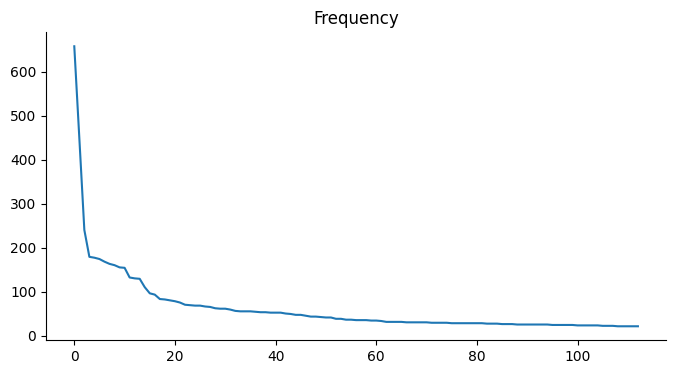

In [60]:
from matplotlib import pyplot as plt
view_df['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

### Comparison of key word extraction methods

In [150]:
csv_eng['statement'][43]

'stacey georgias abrams tre gets reopening covid'

In [151]:
csv_eng['claim'][43]

' “Since the reopening of (the state of Georgia), we’ve seen our COVID rate skyrocket by 40%.”'

In [156]:
keyWordList = extract_keyword_noun(csv_eng['claim'][43])

textGoogle = ' '.join(keyWordList) + " wikipedia"

In [157]:
textGoogle

'Since reopening state Georgia seen COVID rate skyrocket wikipedia'

## Fetching wikipedia articles

In [ ]:
!pip install wikipedia

### Similarity between two strings (abandonned)

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import wikipedia

def get_wikipedia_content(title):
    try:
        page = wikipedia.page(title)
        return page.content
    except wikipedia.DisambiguationError as e:
        # Handle disambiguation pages if needed
        print(f"DisambiguationError: {e}")
    except wikipedia.HTTPTimeoutError as e:
        print(f"HTTPTimeoutError: {e}")
    except wikipedia.PageError as e:
        print(f"PageError: {e}")
    return None

def extract_correlated_articles(fake_news_claim, wikipedia_articles):
    correlated_articles = []

    # Vectorize the fake news claim
    vectorizer = TfidfVectorizer()
    fake_news_vector = vectorizer.fit_transform([fake_news_claim])

    for article_title in wikipedia_articles:
        # Get the content of the Wikipedia article
        article_content = get_wikipedia_content(article_title)

        if article_content:
            # Vectorize the Wikipedia article content
            article_vector = vectorizer.transform([article_content])

            # Calculate cosine similarity
            similarity_score = cosine_similarity(fake_news_vector, article_vector)[0][0]

            # If similarity is above a certain threshold (e.g., 0.5), consider it correlated
            if similarity_score > 0.5:
                correlated_articles.append((article_title, similarity_score))

    # Sort the correlated articles by similarity score in descending order
    correlated_articles = sorted(correlated_articles, key=lambda x: x[1], reverse=True)

    return correlated_articles

# Example usage:
fake_news_claim = "Climate change is a hoax. I love to eat Barbecue"
wikipedia_articles = ["COVID-19 misinformation"]

result = extract_correlated_articles(fake_news_claim, wikipedia_articles)

PageError: Page id "global waring" does not match any pages. Try another id!
Article: Climate_change, Similarity: 0.647034415252922
Article: Renewable energy, Similarity: 0.5142304830430823
Article: Gates, Similarity: 0.5006316288165271


In [100]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import wikipedia

def extract_correlated_articles(fake_news_claim, wikipedia_articles):
    def get_wikipedia_content(title):
        try:
            page = wikipedia.page(title)
            return page.content
        except wikipedia.DisambiguationError as e:
            print(f"DisambiguationError: {e}")
        except wikipedia.HTTPTimeoutError as e:
            print(f"HTTPTimeoutError: {e}")
        except wikipedia.PageError as e:
            print(f"PageError: {e}")
        return None

    correlated_articles = []

    # Vectorize the fake news claim
    vectorizer = TfidfVectorizer()
    fake_news_vector = vectorizer.fit_transform([fake_news_claim])

    for article_title in wikipedia_articles:
        # Get the content of the Wikipedia article
        article_content = get_wikipedia_content(article_title)

        if article_content:
            # Vectorize the Wikipedia article content
            article_vector = vectorizer.transform([article_content])

            # Calculate cosine similarity
            similarity_score = cosine_similarity(fake_news_vector, article_vector)[0][0]

            # If similarity is above a certain threshold (e.g., 0.5), consider it correlated
            if similarity_score > 0.5:
                correlated_articles.append((article_title, similarity_score))

    # Sort the correlated articles by similarity score in descending order
    correlated_articles = sorted(correlated_articles, key=lambda x: x[1], reverse=True)

    return correlated_articles

def process_dataframe_claims(df, column_name, wikipedia_articles):
    # Dictionary to store results
    results = {}

    for index, row in df.iterrows():
        print(index)
        fake_news_claim = row[column_name]
        correlated_articles = extract_correlated_articles(fake_news_claim, wikipedia_articles)
        results[fake_news_claim] = correlated_articles

    return results

# Example usage:
df = pd.DataFrame(csv_eng.iloc[12:22])
wikipedia_articles = ["COVID-19 misinformation"]

result = process_dataframe_claims(df, 'claim', wikipedia_articles)


12
13
14
15
16
17
18
19
20
21


In [142]:
result

{' The image of an intubated baby with a large chest scar has been shared tens of thousands of times on Facebook, with claims that the infant had recently survived heart surgery before testing positive for the novel coronavirus.': [('COVID-19 misinformation',
   0.671835362195927)],
 ' The fire incident at Rohini flyover in Delhi, India is caused by hand sanitiser.': [],
 ' A video purporting to show several dead bodies lying beside coronavirus patients in a hospital ward has been viewed thousands of times in multiple posts on Facebook and Twitter alongside a claim it was filmed in the Indian capital of Delhi.': [('COVID-19 misinformation',
   0.531225241420052)],
 ' Man seen in viral images was a COVID-19 patient who fell in love with his lady doctor. The two got engaged in the same hospital in Egypt.': [('COVID-19 misinformation',
   0.6179598215186103)],
 ' Italy “went against the WHO’s ‘law’” against COVID-19 autopsies and “discovered covid is not a virus, but a bacterium” that “cl

### Getting urls from google searches

In [146]:
text = "The image of an intubated baby with a large chest scar has been shared tens of thousands of times on Facebook, with claims that the infant had recently survived heart surgery before testing positive for the novel coronavirus."
text = extract_keyword_noun(text)
text

array(['image', 'intubated', 'baby', 'large', 'chest', 'scar', 'shared',
       'tens', 'thousands', 'times', 'Facebook', 'claims', 'infant',
       'recently', 'survived', 'heart', 'surgery', 'testing', 'positive',
       'novel', 'coronavirus'], dtype='<U11')

In [159]:
from googlesearch import search

def get_wikipedia_urls(query):
    wikipedia_urls = []
    # Searching the query on Google
    for j in search(query, num=100, stop=100, pause=2):
        if "wikipedia.org" in j:
            wikipedia_urls.append(j.replace("https://en.wikipedia.org/wiki/", ""))
    return wikipedia_urls

In [164]:
csv_eng['claim'][2]

' A purported screenshot of an Australian Department of Health webpage has been shared repeatedly on Facebook alongside a claim it is evidence that COVID-19 tests “cannot distinguish covid from a cold or measles or ebola”.'

In [184]:
# Example usage
text = csv_eng['claim'][2]
keyWordList = extract_keyword_noun(text)
query = ' '.join(keyWordList) + " wikipedia"
wikipedia_urls = get_wikipedia_urls(query)
print(wikipedia_urls)


[]


In [185]:
keyWordList

array(['purported', 'screenshot', 'Australian', 'Department', 'Health',
       'webpage', 'repeatedly', 'Facebook', 'alongside', 'claim',
       'evidence', 'COVID-19', 'tests', 'covid', 'cold', 'measles'],
      dtype='<U10')

In [161]:
sum(wiki_topics["index"].isin(wikipedia_urls))

5